<a href="https://colab.research.google.com/github/JontySinai/ProbabilisticProgramming/blob/master/my_BayesianMethodsForHackers/3_MCMC.ipynb">
  <img style="float: left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Bayesian Methods for Hackers
## MCMC
**Chapter 03 - Intro to MCMC**<br>

**Source:** https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/tree/master/Chapter3_MCMC

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    !pip3 install -q wget
    import wget

In [129]:
import os
import typing

from typing import Dict, List, Tuple

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from IPython.core.pylabtools import figsize

import numpy as np
import pandas as pd
import scipy.stats as stats

import pymc3 as pm
import theano.tensor as tt

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

np.random.seed(1901)

def session_options(enable_gpu_ram_resizing=True, enable_xla=False):
    """
    Allowing the notebook to make use of GPUs if they're available.

    XLA (Accelerated Linear Algebra) is a domain-specific compiler for linear
    algebra that optimizes TensorFlow computations.
    """
    config = tf.config
    gpu_devices = config.experimental.list_physical_devices('GPU')
    if enable_gpu_ram_resizing:
        for device in gpu_devices:
            tf.config.experimental.set_memory_growth(device, True)
    if enable_xla:
        config.optimizer.set_jit(True)
    return config

session_options(enable_gpu_ram_resizing=True, enable_xla=True)

<module 'tensorflow._api.v2.config' from '/home/josinai/anaconda3/envs/axiom/lib/python3.7/site-packages/tensorflow/_api/v2/config/__init__.py'>

## Prior Landscape

We can think of a prior distribution on $N$ random variables as a surface which reflects the prior probability of every point. For example, if we have two random variables $x_1$ and $x_2$ with a uniform prior $\mathscr{U}(0,5)^2$, then the prior distribution will be a square of equal probability over the cartesian product $(0,5)^2$:

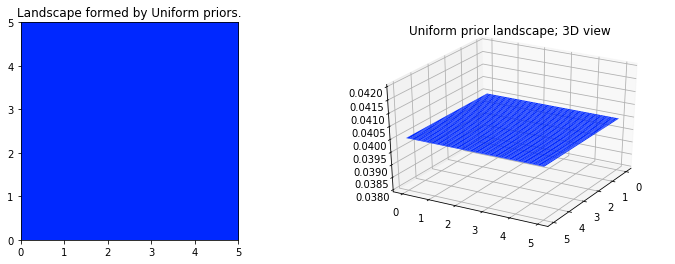

In [5]:
x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

x_uniform = stats.uniform.pdf(x, loc=0, scale=5)
y_uniform = stats.uniform.pdf(y, loc=0, scale=5)
M = np.dot(x_uniform[:, None], y_uniform[None, :])  # [:, None] -> column vector ; [None, :] -> row vector

jet = plt.cm.jet

fig = plt.figure(figsize=(12.5, 4))

plt.subplot(121)
plt.imshow(M, interpolation='none', origin='lower',
           cmap=jet, vmax=1, vmin=-0.15, extent=(0,5,0,5))
plt.title("Landscape formed by Uniform priors.")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=plt.cm.jet, vmax=1, vmin=-.15)
ax.view_init(azim=390)
plt.title("Uniform prior landscape; 3D view");


More interestingly, suppose we place exponential priors on the random variables: $Exp(3)$ and $Exp(10)$:

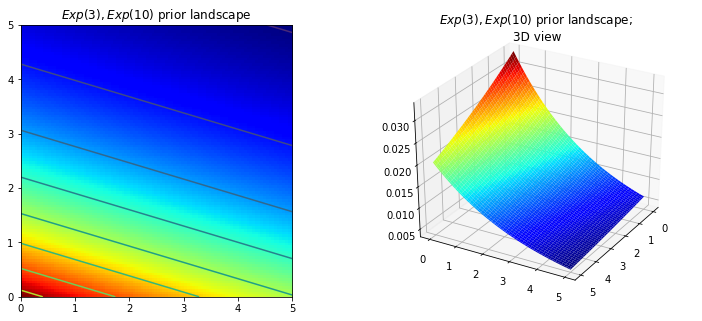

In [6]:
x_exp = stats.expon.pdf(x, scale=3)
y_exp = stats.expon.pdf(x, scale=10)
M = np.dot(x_exp[:, None], y_exp[None, :])

fig = plt.figure(figsize=(12.5, 5))

plt.subplot(121)
plt.contour(X, Y, M)
plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.title("$Exp(3), Exp(10)$ prior landscape")

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=jet)
ax.view_init(azim=390)
plt.title("$Exp(3), Exp(10)$ prior landscape; \n3D view");

## Posterior Landscape

When we add data to our observations, we don't change the underlying space for the random variables, but we do change the surface which lies on top. This is what happens when we transform a prior distribution to a posterior distribution. The posterior distribution will contort to place higher probability on the location where the true values of the variables are likely to lie, given the observed data. 

Let's see how a single data point will change the prior landscape, supposing that the priors above represent the parameters $\lambda_1, \lambda_2$ of two independent Poisson distributions:

In [22]:
# sample size of data we observe, trying varying this (keep it less than 100 ;)
N = 5

# the true parameters, but of course we do not see these values...
lambda_1_true = 1
lambda_2_true = 3

#...we see the data generated, dependent on the above two values.
data = np.concatenate([
    stats.poisson.rvs(lambda_1_true, size=(N, 1)),
    stats.poisson.rvs(lambda_2_true, size=(N, 1))
], axis=1)
print("observed (2-dimensional,sample size = %d):" % N, data)

observed (2-dimensional,sample size = 5): [[1 3]
 [1 2]
 [0 5]
 [0 5]
 [2 3]]


In [23]:
# likelihood
x = y = np.linspace(.01, 5, 100)
likelihood_x = np.array([stats.poisson.pmf(data[:, 0], _x)
                        for _x in x]).prod(axis=1)
likelihood_y = np.array([stats.poisson.pmf(data[:, 1], _y)
                        for _y in y]).prod(axis=1)
L = np.dot(likelihood_x[:, None], likelihood_y[None, :])

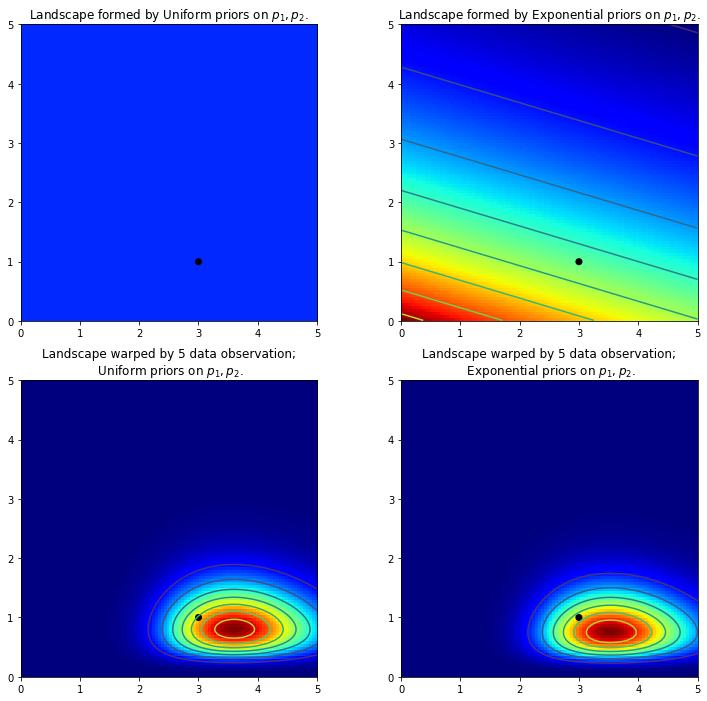

In [24]:
figsize(12.5, 12)
# matplotlib heavy lifting below, beware!
plt.subplot(221)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(x, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Uniform priors on $p_1, p_2$.")

plt.subplot(223)
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.title("Landscape warped by %d data observation;\n Uniform priors on $p_1, p_2$." % N)
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)

plt.subplot(222)
exp_x = stats.expon.pdf(x, loc=0, scale=3)
exp_y = stats.expon.pdf(x, loc=0, scale=10)
M = np.dot(exp_x[:, None], exp_y[None, :])

plt.contour(x, y, M)
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))
plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title("Landscape formed by Exponential priors on $p_1, p_2$.")

plt.subplot(224)
# This is the likelihood times prior, that results in the posterior.
plt.contour(x, y, M * L)
im = plt.imshow(M * L, interpolation='none', origin='lower',
                cmap=jet, extent=(0, 5, 0, 5))

plt.scatter(lambda_2_true, lambda_1_true, c="k", s=50, edgecolor="none")
plt.title("Landscape warped by %d data observation;\n Exponential priors on \
$p_1, p_2$." % N)
plt.xlim(0, 5)
plt.ylim(0, 5);


# Exploring the Landscape using MCMC

Markov Chain Monte Carlo algorithms attempt to explore the posterior surface by successfully sampling from an approximation of the unknown posterior. Each time we sample a new point, we transform the prior distribution until eventually we settle on a posterior landscape which hopefully resembles the true posterior as much as possible.

>The details of how this is achieved is the main purpose of study of Monte Carlo methods.

We can think of MCMC algorithms as a stochastic search of the posterior landscape.

## Generic Algorithm

0. Choose an initial position $x^0$
1. For t > 0 until stopping criteria met:\
    i. Propose a new position $x^t \sim P\big( x \;|\; x^{t-1}\big)$\
    ii. Accept\reject the new position:
     - If accept: move to $x^t$
     - If reject: remain on $x^{t-1}$
 
 
2. Once stopping criteria has been met, return all accepted samples.

# Example: Mixture Model

We want to cluster data using a mixture model:

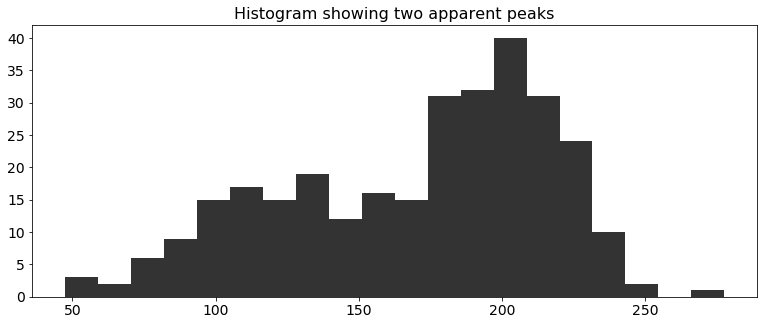

In [97]:
filepath = "mixture_data.csv"

if IN_COLAB:
    print('Fetching data from Github ...')
    url = 'https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter3_MCMC/data/mixture_data.csv'
    _data = wget.download(url, )
else:
    filepath = os.path.join("data", filepath)

mixture_data = np.genfromtxt(filepath,
                             delimiter=",")

figsize(13, 5)
plt.hist(mixture_data,
         bins=20,
         histtype='stepfilled',
         color='black',
         alpha=0.8)
plt.title('Histogram showing two apparent peaks', fontsize=16);

The data suggests that the true distribution is a mixture of two Gaussians, representing each cluster:

$$\mathscr{N}_1 = \mathscr{N}\big(\; \mu_1, \sigma_1^2 \big) \;,\; \mathscr{N}_2 = \mathscr{N}\big(\; \mu_2, \sigma_2^2 \big)$$

We can assume that the data is then generated from the following process:

For each data point:
1. Choose cluster 1 with probability $p$ ($i = 1$), else choose cluster 2 ($i = 2$)
2. Draw a random sample from a Normal distribution $\mathscr{N}_i$.

We can represent the probabilitiies of choosing each cluster in `PyMC3` using the `Categorical` stochastic variable class which is a vector of probabilities of length $k$, summing to $1$, with `value` attribute an integer between $0$ and $k-1$.

Since we don't know what the probability $p$ is, we can assume that it is drawn from a Uniform prior on $(0, 1)$:

## Algorithm in PyMC3

In [52]:
with pm.Model() as model:
    p1 = pm.Uniform('p', 0, 1)
    p2 = 1 - p1
    p = tt.stack([p1, p2])
    assignment = pm.Categorical('assignment', p,
                               shape=mixture_data.shape[0],
                               testval=np.random.randint(0, 2, mixture_data.shape[0]))
    
print(f'Prior cluster assignments, with p = {p1.tag.test_value:.2f}:')
print(assignment.tag.test_value[:10])

Prior cluster assignments, with p = 0.50:
[0 1 0 1 0 0 0 1 0 1]


Now let's incorporate the two normal distributions. Note that since $\mu_i, \sigma_i^2$ are both unknown, we also need to include priors on them. We will model $\sigma_1^2, \sigma_2^2$ from a uniform prior on (0, 100) each. We can model the means using a normal prior. Looking at the data we can guess that $\mu_1 \approx 120 \;,\; \mu_2 \approx 190$, give or take a standard deviation of $10$.

In [53]:
with model:
    sigmas = pm.Uniform('sigmas', 0, 100, shape=2)  # note that both columns are independent
    mus = pm.Normal('mus',
                    mu=np.array([120, 190]),
                    sd=np.array([10, 10]),
                    shape=2)
    
    mu_i = pm.Deterministic('mu_i', mus[assignment])
    sigma_i = pm.Deterministic('sigma_i', sigmas[assignment])
    
    observations = pm.Normal('obs',
                             mu=mu_i,
                             sd=sigma_i,
                             observed=mixture_data)

print("Random assignments: ", assignment.tag.test_value[:4], "...")
print("Assigned center: ", mu_i.tag.test_value[:4], "...")
print("Assigned standard deviation: ", sigma_i.tag.test_value[:4])

Random assignments:  [0 1 0 1] ...
Assigned center:  [120. 190. 120. 190.] ...
Assigned standard deviation:  [50. 50. 50. 50.]


Now let's perform several samples of the Metropolis-Hastings algorithm. Note that we will sample the unknown parameters using the Metropolis-Hastings accept-reject procedure, whereas the cluster assignment will be deterministic based on the value of $p$.

In [56]:
with model:
    step1 = pm.Metropolis(vars=[p, sigmas, mus])
    step2 = pm.ElemwiseCategorical(vars=[assignment])
    trace = pm.sample(25000, chains=1, tune=0, step=[step1, step2])

/home/josinai/anaconda3/envs/axiom/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  This is separate from the ipykernel package so we can avoid doing imports until
Sequential sampling (1 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [mus]
>>Metropolis: [sigmas]
>>Metropolis: [p]
>ElemwiseCategorical: [assignment]
100%|██████████| 25000/25000 [01:59<00:00, 208.83it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


## Exploring the Markov Chain Trace

The _Markov trace_ stores the samples for each variable. In `PyMC3`, each variable is indexed in the `trace` by its variable `name`.

We can observe the path that each variable took along the Markov chain by plotting the trace along each time step (when the random variables are in $\mathbb{R}$).

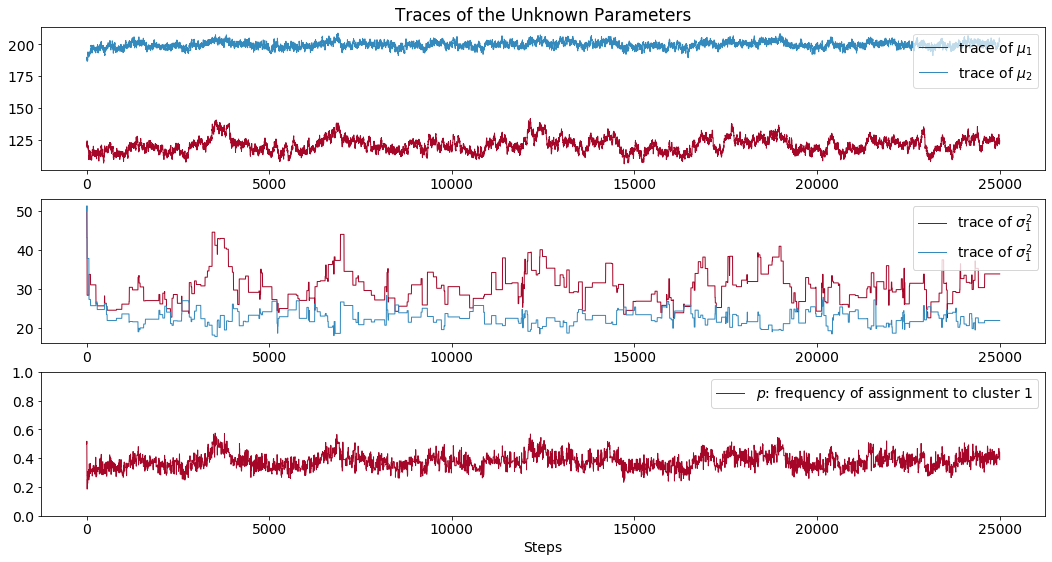

In [57]:
plt.rcParams.update({'font.size': 14})
figsize(18, 9)

plt.subplot(311)
mu_trace = trace['mus']

colors = ["#348ABD", "#A60628"] if mu_trace[-1, 0] > mu_trace[-1, 1] \
    else ["#A60628", "#348ABD"]

plt.plot(mu_trace[:, 0], label=r"trace of $\mu_1$", c=colors[0], lw=1)
plt.plot(mu_trace[:, 1], label=r"trace of $\mu_2$", c=colors[1], lw=1)
plt.title("Traces of the Unknown Parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

plt.subplot(312)
sigma_trace = trace["sigmas"]
plt.plot(sigma_trace[:, 0], label=r"trace of $\sigma_1^2$", c=colors[0], lw=1)
plt.plot(sigma_trace[:, 1], label=r"trace of $\sigma_1^2$", c=colors[1], lw=1)
plt.legend(loc="upper right")

plt.subplot(313)
p_trace = trace["p"]
plt.plot(p_trace, label="$p$: frequency of assignment to cluster 1", color=colors[0], lw=1)
plt.xlabel("Steps")
plt.ylim(0, 1)
plt.legend(loc='upper right');

### Burn-in

In general it is a bad idea to use the first portion of the trace (say first 25%) as these samples are more likely to be far away from the true posterior. We call this period the _burn-in_ period and it is good practice to discard those samples from the posterior estimation.

For example, we can run the Markov chain for a bit longer:

In [58]:
with model:
    trace = pm.sample(50000, chains=1, tune=0, step=[step1, step2], trace=trace)

Sequential sampling (1 chains in 1 job)
CompoundStep
>CompoundStep
>>Metropolis: [mus]
>>Metropolis: [sigmas]
>>Metropolis: [p]
>ElemwiseCategorical: [assignment]
100%|██████████| 50000/50000 [04:00<00:00, 208.20it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


As an example we can check how the trace for $\mu_1$ and $\mu_2$ evolve beyond the first 25000 iterations

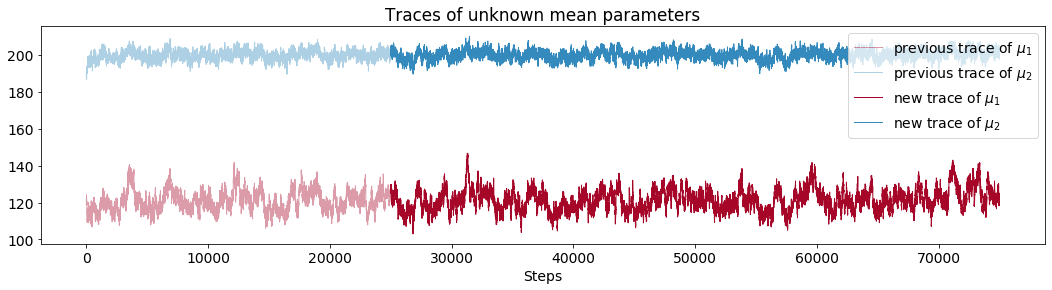

In [99]:
figsize(18, 4)
mu_trace = trace["mus"][25000:]
prev_mu_trace = trace["mus"][:25000]

x = np.arange(25000)
plt.plot(x, prev_mu_trace[:, 0], label=r"previous trace of $\mu_1$", lw=1, alpha=0.4, c=colors[0])
plt.plot(x, prev_mu_trace[:, 1], label=r"previous trace of $\mu_2$", lw=1, alpha=0.4, c=colors[1])

x = np.arange(25000, 75000)
plt.plot(x, mu_trace[:, 0], label=r"new trace of $\mu_1$", lw=1, c="#A60628")
plt.plot(x, mu_trace[:, 1], label=r"new trace of $\mu_2$", lw=1, c="#348ABD") 

plt.title("Traces of unknown mean parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.8)
plt.xlabel("Steps");


## Posterior Distributions

Let's now investigate the posterior distributions of each parameter

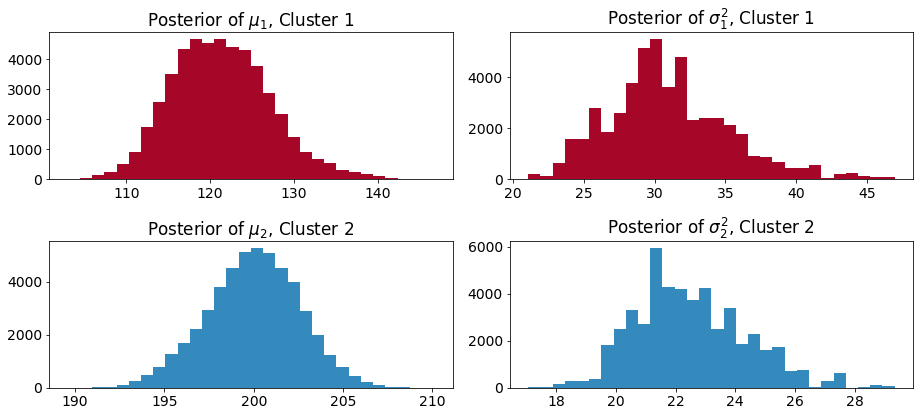

In [70]:
figsize(13, 6)
sigma_trace = trace["sigmas"][25000:]

_i = [1, 2, 3, 4]
for i in range(2):
    plt.subplot(2, 2, _i[2 * i])
    plt.title(r"Posterior of $\mu_%d$, Cluster %d" % (i+1, i+1))
    plt.hist(mu_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")

    plt.subplot(2, 2, _i[2 * i + 1])
    plt.title(r"Posterior of $\sigma_%d^2$, Cluster %d" % (i+1, i+1))
    plt.hist(sigma_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")
    # plt.autoscale(tight=True)

plt.tight_layout()

## Cluster Assignment

Cluster assignment is essentially an unsupervised classification problem. Given the value of the data point, we can check the probability that the data point lies in cluster 1.

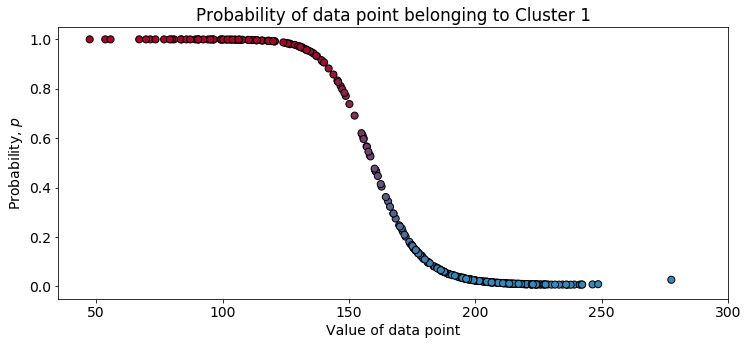

In [100]:
cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)

assign_trace = trace["assignment"]

plt.rcParams.update({'font.size': 14})
figsize(12, 5)

plt.scatter(x=mixture_data, 
            y=1 - assign_trace.mean(axis=0), 
            cmap=cmap,
            c=assign_trace.mean(axis=0),
            edgecolors='black',
            s=50)
plt.ylim(-0.05, 1.05)
plt.xlim(35, 300)
plt.title("Probability of data point belonging to Cluster 1")
plt.ylabel(r"Probability, $p$")
plt.xlabel("Value of data point");

## Finally, let's model our clusters against the histogram of the data

Recall that our trace gives us many samples for the parameters of each normal distribution. The typical practice is to use the mean of the trace samples for each parameter:

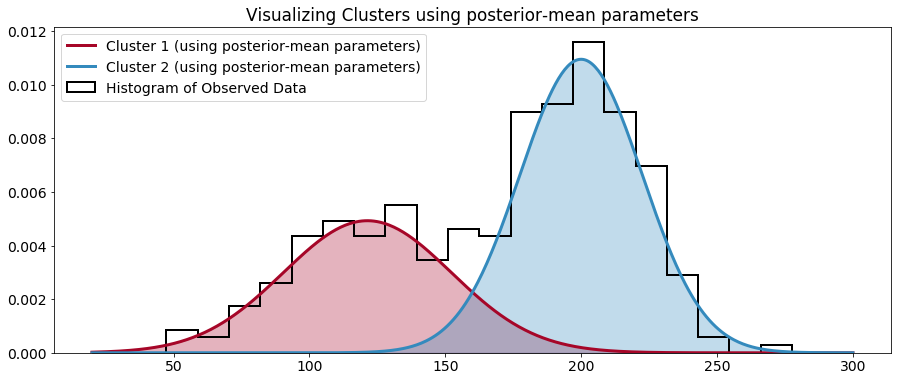

In [105]:
x = np.linspace(20, 300, 500)
posterior_mu_means = mu_trace.mean(axis=0)
posterior_sigma_means = sigma_trace.mean(axis=0)
posterior_p_mean = trace["p"].mean()

figsize(15, 6)

# original data
plt.hist(mixture_data, 
         label="Histogram of Observed Data", 
         bins=20, 
         histtype="step", 
         density=True, 
         color="black",
         lw=2)

# cluster 1
pdf_cluster_1 = posterior_p_mean * stats.norm.pdf(x, 
                                                  loc=posterior_mu_means[0],
                                                  scale=posterior_sigma_means[0])
plt.plot(x, 
         pdf_cluster_1, 
         label="Cluster 1 (using posterior-mean parameters)",
         color=colors[0],
         lw=3)
plt.fill_between(x, pdf_cluster_1, color=colors[0], alpha=0.3)

pdf_cluster_2 = (1 - posterior_p_mean) * stats.norm.pdf(x, 
                                                        loc=posterior_mu_means[1],
                                                        scale=posterior_sigma_means[1])
plt.plot(x, 
         pdf_cluster_2, 
         label="Cluster 2 (using posterior-mean parameters)",
         color=colors[1],
         lw=3)
plt.fill_between(x, pdf_cluster_2, color=colors[1], alpha=0.3)

plt.legend(loc="upper left")
plt.title("Visualizing Clusters using posterior-mean parameters");


# Prediction

Since we have a Bayesian posterior model, it makes sense to take advantage of the posterior distribution for predictions. So if we wanted to predict which cluster a new data point $x^*$ belongs to, we should try and predict the probabilities:

$$P\big(x=x^* \;|\;i=k\big), \quad \text{for } k=1,2...K,$$

where $K$ is the number of clusters. We then choose $k$ which maximises the probability of assignment. But since we want to calculate the posterior probabilities, we need to also include the prior probabilities on the clusters. So from Bayes' Theorem, what we really want to calculate is:

$$P\big(x=x^* \;|\;i=k\big)P\big( i=k \big), \quad \text{for } k=1,2...K,$$



In [106]:
p_trace = trace["p"][25000:]

x_new = 175

prior_cluster_1 = p_trace
likelihood_cluster_1 = stats.norm.pdf(x_new, loc=mu_trace[:, 0], scale=sigma_trace[:, 0])

prior_cluster_2 = 1 - p_trace
likelihood_cluster_2 = stats.norm.pdf(x_new, loc=mu_trace[:, 1], scale=sigma_trace[:, 1])

predictive_assignment_vector = prior_cluster_1 * likelihood_cluster_1 > prior_cluster_2 * likelihood_cluster_2
print("Probability of belonging to cluster 1:", predictive_assignment_vector.mean())

Probability of belonging to cluster 1: 0.00858


We can then use the posterior probability to assign `x_new` to a cluster. How we do so will depend on optimizing a loss function for the purpose.

# Convergence

## Starting at the MAP estimate:

Given enought time, a Markov chain should converge to the true posterior regardless of the initial distribution. However we only have finite computation time, and hence the approximate posterior is still a function of the initial distribution. If we could choose a reasonable starting position we can improve our chances that the approximate posterior is reasonable.

One way of choosing a starting position is to use the MAP estimate which can be estimated using simple gradient based techniques. The default optimizer is BFGS ([Boyden-Fletcher-Goldfarb-Shanno algorithm](https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm)). The optimizer can also be specified, using one of the optimizers from `scipy.optimize` using the `fmin` argument in `pm.find_MAP`.

`PyMC3` provides a function for computing a MAP estimate which we can set as the initial distribution of the Markov chain:

    start = pm.find_MAP()
    trace = pm.sample(N_SAMPLES, step=pm.Metropolis, start=start)
    
It is still important to inspect the trace and discard the burn-in period.    


## Diagnosing convergence

#### Autocorrelation

We can use correlation to determine if the chain has converged. Recall that the Markov chain basically returns samples based on the previous sample. However once the chain has converged to a posterior, we will find that that samples will be uncorrelated (in fact this is one way of defining convergence on a Markov chain!). 

As an extreme example lets consider two stochastic processes, one which is essentially _random noise_ and one which is _highly correlated_. 

$$x_t \sim \text{Normal}(0,1), \;\; x_0 = 0$$
$$y_t \sim \text{Normal}(y_{t-1}, 1 ), \;\; y_0 = 0$$

The processes have sample paths:

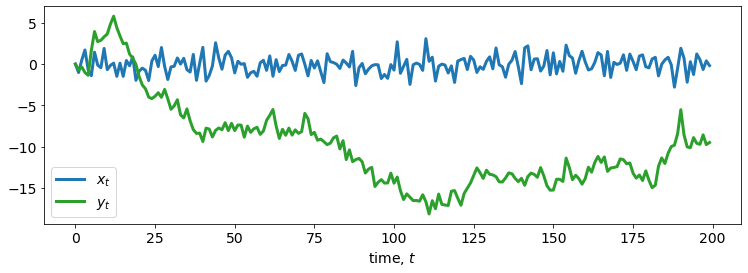

In [112]:
figsize(12.5, 4)

x_t = np.random.normal(0, 1, 200)
x_t[0] = 0
y_t = np.zeros(200)
for i in range(1, 200):
    y_t[i] = np.random.normal(y_t[i - 1], 1)

plt.plot(x_t, label="$x_t$", color='tab:blue', lw=3)
plt.plot(y_t, label="$y_t$", color='tab:green', lw=3)
plt.xlabel("time, $t$")
plt.legend();

The _autocorrelation function of lag k_ will measure:

$$ACF(k) = Corr( x_t, x_{t-k} ) $$

In [109]:
def autocorr(x):
    # from http://tinyurl.com/afz57c4
    # calculates the correlation for lags up to len(x)
    result = np.correlate(x, x, mode='full')
    result = result / np.max(result)
    return result[result.size // 2:]

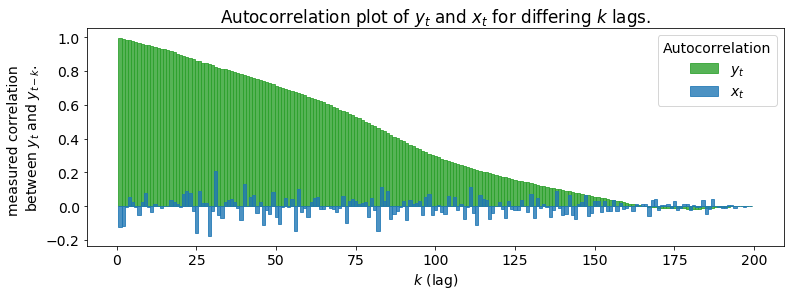

In [117]:
x = np.arange(1, 200)
plt.bar(x, autocorr(y_t)[1:], width=1, label="$y_t$", 
        color='tab:green', edgecolor='tab:green', alpha=0.8)
plt.bar(x, autocorr(x_t)[1:], width=1, label="$x_t$",
        color='tab:blue', edgecolor='tab:blue', alpha=0.8)

plt.legend(title="Autocorrelation")
plt.ylabel("measured correlation \nbetween $y_t$ and $y_{t-k}$.")
plt.xlabel("$k$ (lag)")
plt.title("Autocorrelation plot of $y_t$ and $x_t$ for differing $k$ lags.");

We can see how the correlation for $y$ diminishes with lag, whereas for $x$, the autocorrelation function is effectively random noise. Based on this shape we can conclude that $y$ is highly correlated whereas no autocorrelation exists for $x$.

### Reducing Autocorrelation in MCMC using Thinning

We can reduce the prevalence of autocorrelation in the Markov chain using _thinning_ where we choose every other sample instead of all executive samples. Since $x_t \sim x_{t-1}$, we assume that $x_t$ will be less correlated to $x_{t-l}$, $l > 1$.

Below we can compare the autocorrelation functions for $y$ using different levels of thinning:

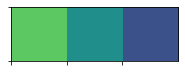

In [120]:
viridis_3 = sns.color_palette('viridis_r', 3)
sns.palplot(viridis_3)

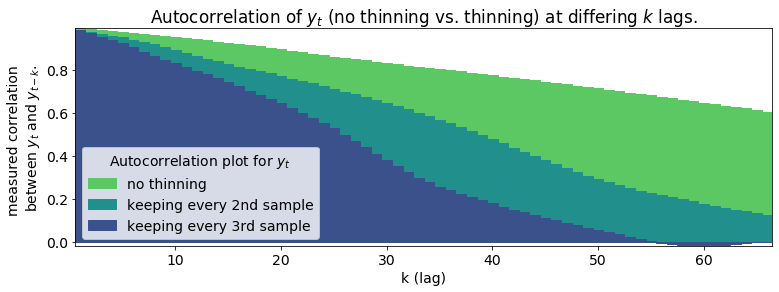

In [121]:
max_x = 200 // 3 + 1
x = np.arange(1, max_x)

plt.bar(x, autocorr(y_t)[1:max_x],label="no thinning",
        edgecolor=viridis_3[0], color=viridis_3[0], width=1)
plt.bar(x, autocorr(y_t[::2])[1:max_x], label="keeping every 2nd sample", 
        edgecolor=viridis_3[1], color=viridis_3[1], width=1)
plt.bar(x, autocorr(y_t[::3])[1:max_x], width=1, label="keeping every 3rd sample",
        edgecolor=viridis_3[2], color=viridis_3[2])

plt.autoscale(tight=True)
plt.legend(title="Autocorrelation plot for $y_t$", loc="lower left")
plt.ylabel("measured correlation \nbetween $y_t$ and $y_{t-k}$.")
plt.xlabel("k (lag)")
plt.title("Autocorrelation of $y_t$ (no thinning vs. thinning) \
at differing $k$ lags.");

The trade-off however is that a higher level of thinning requires a higher number of returned samples.

### PyMC3 plot functions for diagnostics

We can use the following convenience functions to produce similar plots to the ones we manually produced above (albeit with less control of the aesthetics)

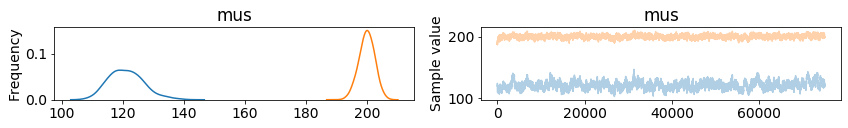

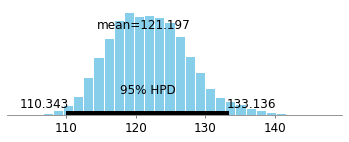

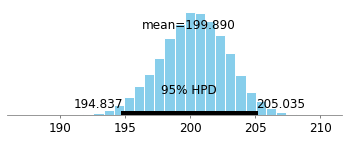

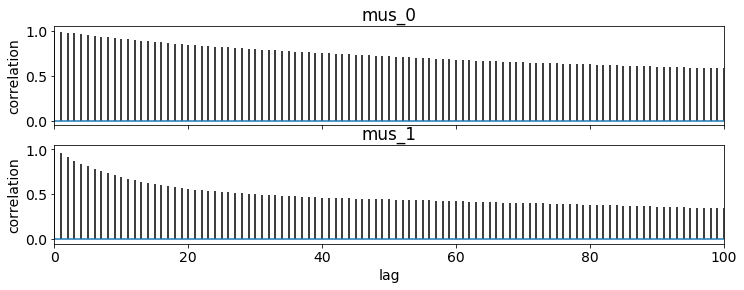

In [123]:
pm.plots.traceplot(trace=trace, varnames=["mus"])
pm.plots.plot_posterior(trace=trace["mus"][:,0])
pm.plots.plot_posterior(trace=trace["mus"][:,1])
pm.plots.autocorrplot(trace=trace, varnames=["mus"]);

# TFP Model

We will now repeat the same using `tensorflow-probability`

In [127]:
matplotlib_style = 'fivethirtyeight'
plt.style.use(matplotlib_style)

class _TFColor(object):
    """Enum of colors used in TF docs."""
    red = '#F15854'
    blue = '#5DA5DA'
    orange = '#FAA43A'
    green = '#60BD68'
    pink = '#F17CB0'
    brown = '#B2912F'
    purple = '#B276B2'
    yellow = '#DECF3F'
    gray = '#4D4D4D'
    def __getitem__(self, i):
        return [
            self.red,
            self.orange,
            self.green,
            self.blue,
            self.pink,
            self.brown,
            self.purple,
            self.yellow,
            self.gray,
        ][i % 9]
TFColor = _TFColor()

We will be executing eagerly:

In [18]:
tf.executing_eagerly()

True

We will use the following evaluate function to retrieve numpy arrays from tensors:

In [132]:
def evaluate(tensors):
    """Evaluates Tensor or EagerTensor to Numpy `ndarray`s.
    Args:
    tensors: Object of `Tensor` or EagerTensor`s; can be `list`, `tuple`,
        `namedtuple` or combinations thereof.

    Returns:
        ndarrays: Object with same structure as `tensors` except with `Tensor` or
          `EagerTensor`s replaced by Numpy `ndarray`s.
    """
    if tf.executing_eagerly():
        return tf.nest.pack_sequence_as(
            tensors,
            [t.numpy() if tf.is_tensor(t) else t for t in tf.nest.flatten(tensors)])
    return sess.run(tensors)

## Mixture Data in TF

Since by convention the numpy arrays will have a "_" suffix, let's make a copy of the challenger data we downloaded and then create the tensor versions from that

In [124]:
mixture_data_ = mixture_data.copy()
mixture_data = tf.convert_to_tensor(mixture_data_, dtype=tf.float32)

print(mixture_data)

tf.Tensor(
[115.85679  152.26154  178.8745   162.93501  107.028206 105.191414
 118.38289  125.37698  102.88054  206.71326  139.36891  155.41048
 148.75931   83.759575 139.90775  120.62239  135.56532  104.88725
 110.00789  118.85137  113.20734  101.46423   53.56402   83.43273
 158.30504  106.41998  155.8244   113.19884  126.770706 137.37883
 120.6954   111.57464  115.44677   99.23199  131.64723   99.96377
 111.42139  124.69059  139.1451   136.15143  130.7115    80.8132
 107.82136  126.25964  171.27426  157.01004   85.705444 113.57179
 137.07654   79.908585  47.406887  67.01135  131.62129  132.71802
 168.50937  133.7699   175.54858  165.52423  126.84718  167.60158
 145.58984  195.61601  118.222466  89.25086  128.62692   99.46177
 157.10612  100.250114 117.87364   94.22954   96.323364 130.97711
 118.13917   87.18474  146.73637  125.7995   103.47233  111.747734
 134.65703  110.411224 124.02796   90.58614  174.35292  145.47354
 120.07744   76.84826  132.76157   92.36097   95.52785  133.2777

## Mixture Density Model in TFP

### 1. Cluster Assignment Parameters

First we will model the probability of assignment, $p = P(i=1;\;|;x)$:

In [133]:
p1 = tfd.Uniform(name='p', low=0., high=1.).sample()
p2 = 1 - p1
p = tf.stack([p1, p2])

rv_assignment = tfd.Categorical(name='assigment', probs=p)
assignment = rv_assignment.sample(sample_shape=mixture_data_.shape[0])

# evaluate tensors
[
    p_,
    assignment_
] = evaluate([
    p,
    assignment
])

print("prior assignment, with p = %.2f:" % p_[0])
print (assignment_[:10])

prior assignment, with p = 0.73:
[0 0 1 0 1 0 0 0 0 0]


### 2. Cluster Density Parameters

Now we will model the parameters for each cluster density:

$$\mathscr{N}_1 = \mathscr{N}\big(\; \mu_1, \sigma_1^2 \big) \;,\; \mathscr{N}_2 = \mathscr{N}\big(\; \mu_2, \sigma_2^2 \big)$$

In [135]:
rv_sigmas = tfd.Uniform(name="sigmas", low=[0., 0.], high=[100., 100.])
rv_mus = tfd.Normal(name="mus", loc=[120., 190.], scale=[10., 10.])

sigmas = rv_sigmas.sample()
mus = rv_mus.sample()

# to combine with the observations we can use the `tfd.MixtureSameFamily` distribution using the Categorical rv
# as the selecting function
rv_observations = tfd.MixtureSameFamily(
                        mixture_distribution=rv_assignment,
                        components_distribution=tfd.Normal(
                                loc=mus,
                                scale=sigmas)
                  )

observations = rv_observations.sample(sample_shape=10)

[    
    observations_,
    sigmas_,
    mus_
] = evaluate([
    observations,
    sigmas,
    mus
])

print("simulated data: ", observations_[:4], "...")
print("Random assignments: ", assignment_[:4], "...")
print("Assigned center: ", mus_[:4], "...")
print("Assigned standard deviation: ", sigmas_[:4],"...")

simulated data:  [116.0353    25.527084  68.86128   96.79382 ] ...
Random assignments:  [0 0 1 0] ...
Assigned center:  [113.84789 178.36221] ...
Assigned standard deviation:  [73.186874 41.780056] ...


### 3. Joint Log Probability Model

We will now put this altogether to define a joint logpdf which we will optimise using Hamiltonian Monte Carlo estimation.

In [136]:
def joint_log_prob(data, sample_prob_1, sample_mus, sample_sigmas):
    """
    Joint log probability optimization function.
        
    Args:
      data: tensor array representation of original data
      sample_prob_1: Scalar representing probability (out of 1.0) of assignment 
        being 0
      sample_sigmas: 2d vector containing standard deviations for both normal dists
        in model
      sample_mus: 2d vector containing centers for both normal dists in model
    Returns: 
      Joint log probability optimization function.
    """ 
    rv_prob = tfd.Uniform(name='rv_prob', low=0., high=1.)
    sample_prob_2 = 1. - sample_prob_1
    rv_assignments = tfd.Categorical(probs=tf.stack([sample_prob_1, sample_prob_2]))
    
    rv_sigmas = tfd.Uniform(name="rv_sigmas", low=[0., 0.], high=[100., 100.])
    rv_mus = tfd.Normal(name="rv_mus", loc=[120., 190.], scale=[10., 10.])
    
    ### Create a mixture of two Gaussians:
    rv_observations = tfd.MixtureSameFamily(
                        mixture_distribution=rv_assignments,
                        components_distribution=tfd.Normal(
                          loc=sample_mus,
                          scale=sample_sigmas)
                      )
    
    return (
        rv_prob.log_prob(sample_prob_1)
        + rv_prob.log_prob(sample_prob_2)
        + tf.reduce_sum(rv_observations.log_prob(data))      # Sum over samples.
        + tf.reduce_sum(rv_mus.log_prob(sample_mus))          # Sum over cluster parameters.
        + tf.reduce_sum(rv_sigmas.log_prob(sample_sigmas))    # Sum over cluster parameters.
    )


In [143]:
# wrap the mcmc sampling call in a @tf.function to speed it up
@tf.function(autograph=False)
def graph_sample_chain(*args, **kwargs):
    return tfp.mcmc.sample_chain(*args, **kwargs)

In [144]:
number_of_steps=25000
num_burnin_steps=1000
num_leapfrog_steps=3
step_size=0.5

# Set the chain's start state.
initial_chain_state = [
    tf.constant(0.5, name='init_probs'),
    tf.constant([120., 190.], name='init_mus'),
    tf.constant([10., 10.], name='init_sigmas')
]

# Since MCMC operates over unconstrained space, we need to transform the
# samples so they live in real-space.
unconstraining_bijectors = [
    tfp.bijectors.Identity(),       # Maps R to R.
    tfp.bijectors.Identity(),       # Maps R to R.
    tfp.bijectors.Identity(),       # Maps R to R.
]

# Define a closure over our joint_log_prob.
unnormalized_posterior_log_prob = lambda *args: joint_log_prob(mixture_data_, *args)


# Defining the HMC
# we need the TransformedTransitionKernel in order to apply the unconstraining bijectors the HMC samplers
hmc_kernel=tfp.mcmc.TransformedTransitionKernel(
               inner_kernel=tfp.mcmc.HamiltonianMonteCarlo(
                   target_log_prob_fn=unnormalized_posterior_log_prob,
                   num_leapfrog_steps=num_leapfrog_steps,
                   step_size=step_size,
                   state_gradients_are_stopped=True
               ),
               bijector=unconstraining_bijectors
            )
# outer kernel which will adapt the stepsize of the HMC sampler
hmc_with_adaptive_step_size = tfp.mcmc.SimpleStepSizeAdaptation(
                                  inner_kernel=hmc_kernel, 
                                  num_adaptation_steps=int(num_burnin_steps * 0.8)
                              )

# Sample from the chain.
[
    posterior_prob,
    posterior_mus,
    posterior_sigmas
], kernel_results = graph_sample_chain(
                        num_results=number_of_steps,
                        num_burnin_steps=burnin,
                        current_state=initial_chain_state,
                        kernel=hmc_with_adaptive_step_size
                    )


/home/josinai/anaconda3/envs/axiom/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:338: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


In [145]:
[
    posterior_prob_,
    posterior_mus_,
    posterior_sigmas_,
    kernel_results_
] = evaluate([
    posterior_prob,
    posterior_mus,
    posterior_sigmas,
    kernel_results
])
    
print("acceptance rate: {}".format(
    kernel_results_.inner_results.inner_results.is_accepted.mean()))
print("final step size: {}".format(
    kernel_results_.inner_results.inner_results.accepted_results.step_size[-100:].mean()))

acceptance rate: 0.81176
final step size: 0.05172465741634369


### 4. Plot Traces of Unknown Variables

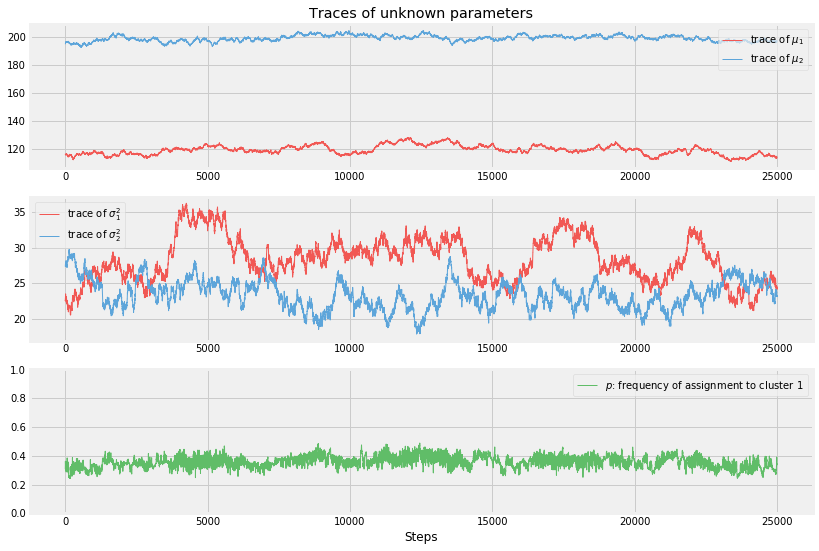

In [147]:
plt.figure(figsize(12.5, 9))
plt.subplot(311)
lw = 1
mu_trace = posterior_mus_

# for pretty colors later in the book.
colors = [TFColor[3], TFColor[0]] if mu_trace[-1, 0] > mu_trace[-1, 1] \
    else [TFColor[0], TFColor[3]]

plt.plot(mu_trace[:, 0], label="trace of $\mu_1$", c=colors[0], lw=lw)
plt.plot(mu_trace[:, 1], label="trace of $\mu_2$", c=colors[1], lw=lw)
plt.title("Traces of unknown parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.7)

plt.subplot(312)
sigma_trace = posterior_sigmas_
plt.plot(sigma_trace[:, 0], label="trace of $\sigma_1^2$",
     c=colors[0], lw=lw)
plt.plot(sigma_trace[:, 1], label="trace of $\sigma_2^2$",
     c=colors[1], lw=lw)
plt.legend(loc="upper left")

plt.subplot(313)
p_trace = posterior_prob_
plt.plot(p_trace, label="$p$: frequency of assignment to cluster 1",
     color=TFColor[2], lw=lw)
plt.xlabel("Steps")
plt.ylim(0, 1)
plt.legend();

### 5. Sample the chain an additional 50000 times

We'll do this by setting the initial chain state to the last chain state of the active trace

In [148]:
number_of_steps=50000
num_burnin_steps=10000

# Set the chain's start state to the last chain state of the active trace.
active_trace_state = [
    tf.constant(posterior_prob_[-1], name='init_probs_2'),
    tf.constant(posterior_mus_[-1], name='init_mus_2'),
    tf.constant(posterior_sigmas_[-1], name='init_sigmas_2')
]

# Sample from the chain.
[
    posterior_prob_2,
    posterior_mus_2,
    posterior_sigmas_2
], kernel_results = graph_sample_chain(
                        num_results=number_of_steps,
                        num_burnin_steps=burnin,
                        current_state=active_trace_state,
                        kernel=hmc_with_adaptive_step_size
                    )


/home/josinai/anaconda3/envs/axiom/lib/python3.7/site-packages/tensorflow_probability/python/mcmc/sample.py:338: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


In [150]:
[
    posterior_prob_2_,
    posterior_mus_2_,
    posterior_sigmas_2_,
    kernel_results_
] = evaluate([
    posterior_prob_2,
    posterior_mus_2,
    posterior_sigmas_2,
    kernel_results
])

print("acceptance rate: {}".format(
    kernel_results_.inner_results.inner_results.is_accepted.mean()))
print("final step size: {}".format(
    kernel_results_.inner_results.inner_results.accepted_results.step_size[-100:].mean()))

acceptance rate: 0.62918
final step size: 0.05490677058696747


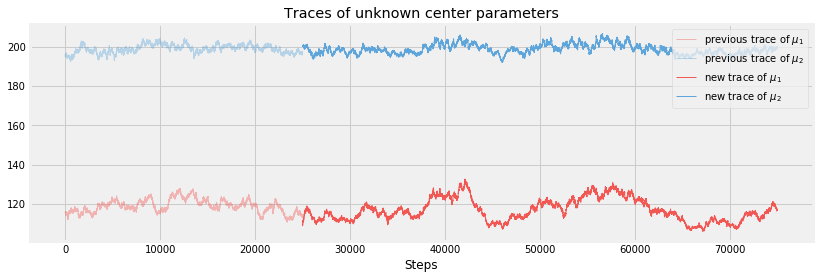

In [152]:
plt.figure(figsize(12.5, 4))
mu_trace = posterior_mus_2_
prev_mu_trace = posterior_mus_

x = np.arange(25000)
plt.plot(x, prev_mu_trace[:, 0], label="previous trace of $\mu_1$",
      lw=lw, alpha=0.4, c=colors[0])
plt.plot(x, prev_mu_trace[:, 1], label="previous trace of $\mu_2$",
      lw=lw, alpha=0.4, c=colors[1])

x = np.arange(25000, 75000)
plt.plot(x, mu_trace[:, 0], label="new trace of $\mu_1$", lw=lw, c="#F15854")
plt.plot(x, mu_trace[:, 1], label="new trace of $\mu_2$", lw=lw, c="#5DA5DA") 

plt.title("Traces of unknown center parameters")
leg = plt.legend(loc="upper right")
leg.get_frame().set_alpha(0.8)
plt.xlabel("Steps");

### 6. Plot Posterior Distributions of Unknown Parameters

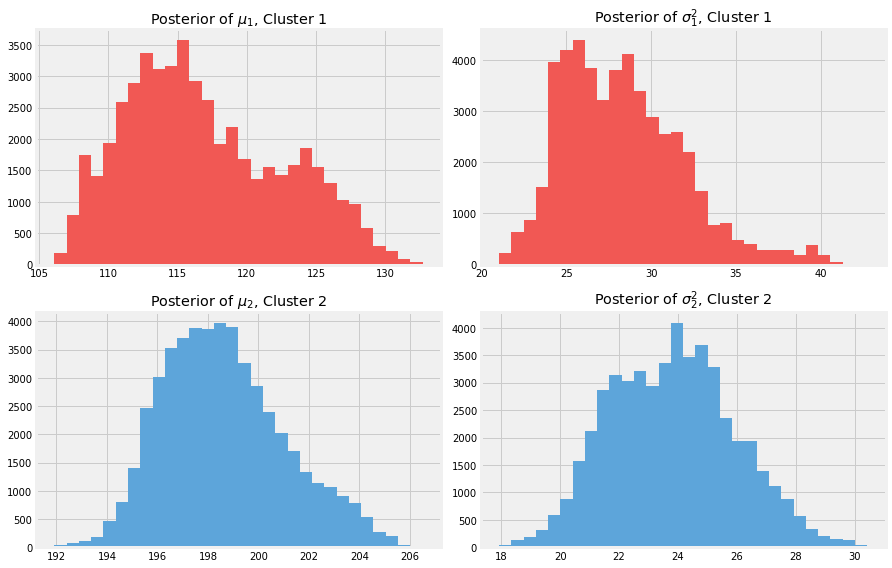

In [153]:
plt.figure(figsize(12.5, 8))
sigma_trace = posterior_sigmas_2_
prev_sigma_trace = posterior_sigmas_

_i = [1, 2, 3, 4]
for i in range(2):
    plt.subplot(2, 2, _i[2 * i])
    plt.title(r"Posterior of $\mu_%d$, Cluster %d" % (i+1, i+1))
    plt.hist(mu_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")

    plt.subplot(2, 2, _i[2 * i + 1])
    plt.title(r"Posterior of $\sigma_%d^2$, Cluster %d" % (i+1, i+1))
    plt.hist(sigma_trace[:, i], color=colors[i], bins=30,
             histtype="stepfilled")
    # plt.autoscale(tight=True)

plt.tight_layout()


### 7. Probability of Assignment

Unlike the `PyMC3` version of this model, the `TensorFlow Probability` model marginalizes (integrates) out the assignment variable in the `tfd.MixtureSameFamily` distribution class. Therefore we don't have a trace for the assignment variable. 

As a substitute we can compute a posterior distribution over the assignments and draw samples from it.

In [154]:
# put the data into a tensor
mixture_data = mixture_data[:,tf.newaxis]

# Define the cluster densities using the final chain states ?? what about mean instead??
rv_cluster_1 = tfd.Normal(posterior_mus_2_[:, 0], posterior_sigmas_2_[:, 0])
rv_cluster_2 = tfd.Normal(posterior_mus_2_[:, 1], posterior_sigmas_2_[:, 1])

# Compute the un-normalized log probabilities for each cluster
cluster_1_log_prob = rv_cluster_1.log_prob(mixture_data) + tf.math.log(posterior_prob_2_)
cluster_2_log_prob = rv_cluster_2.log_prob(mixture_data) + tf.math.log(1. - posterior_prob_2_)

x = tf.stack([cluster_1_log_prob, cluster_2_log_prob],axis=-1)
y = tf.math.reduce_logsumexp(x,-1)

# Bayes rule to compute the assignment probability: P(cluster = 1 | data) ∝ P(data | cluster = 1) P(cluster = 1)
log_p_assign_1 = cluster_1_log_prob - tf.math.reduce_logsumexp(tf.stack([cluster_1_log_prob, cluster_2_log_prob], 
                                                                        axis=-1), 
                                                               -1)

# Average across the MCMC chain
log_p_assign_1 = tf.math.reduce_logsumexp(log_p_assign_1, -1) - tf.math.log(tf.cast(log_p_assign_1.shape[-1], tf.float32))
 
p_assign_1 = tf.exp(log_p_assign_1)
p_assign = tf.stack([p_assign_1, 1 - p_assign_1],
                    axis=-1)

# for charting 
probs_assignments = p_assign_1 

We can visualize this process below:

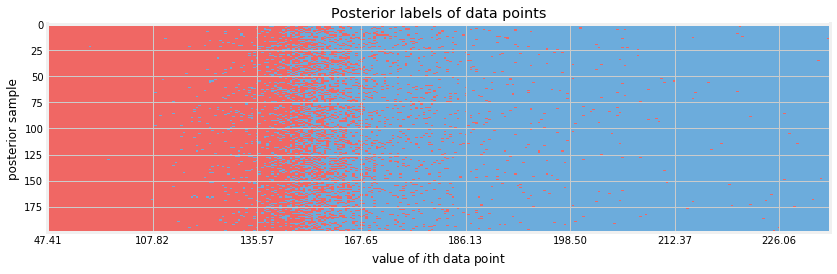

In [158]:
burned_assignment_trace_ = evaluate(tfd.Categorical(probs=p_assign).sample(sample_shape=200))
plt.figure(figsize(12.5, 5))
plt.cmap = mpl.colors.ListedColormap(colors)
plt.imshow(burned_assignment_trace_[:, np.argsort(mixture_data_)],
       cmap=plt.cmap, aspect=.4, alpha=.9)
plt.xticks(np.arange(0, mixture_data_.shape[0], 40),
       ["%.2f" % s for s in np.sort(mixture_data_)[::40]])
plt.ylabel("posterior sample")
plt.xlabel("value of $i$th data point")
plt.title("Posterior labels of data points");

Another way of visualising this is to plot the evolution of the categorical assignment probability:

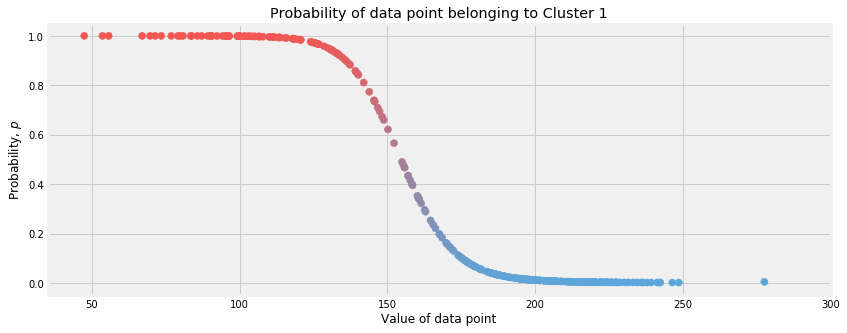

In [163]:
cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)

plt.figure(figsize(12.5, 5))

assign_trace = evaluate(probs_assignments)[np.argsort(mixture_data_)]

plt.scatter(mixture_data_[np.argsort(mixture_data_)], 
            assign_trace, 
            cmap=cmap,
            c=(1 - assign_trace), 
            s=50)
plt.ylim(-0.05, 1.05)
plt.xlim(35, 300)
plt.title("Probability of data point belonging to Cluster 1")
plt.ylabel("Probability, $p$")
plt.xlabel("Value of data point");

### 8. Plot Cluster Densities

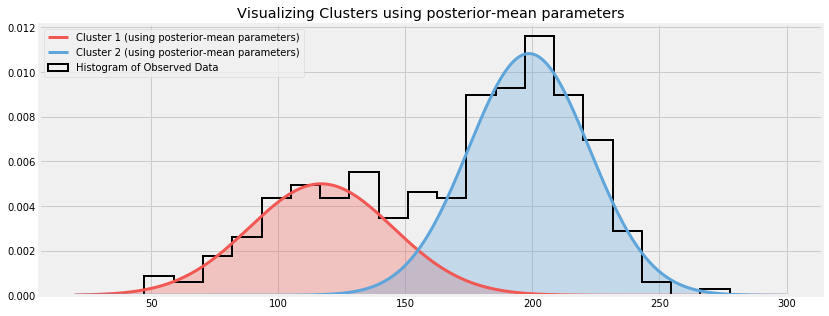

In [168]:
x_ = np.linspace(20, 300, 500)
posterior_mu_means_ = evaluate(tf.reduce_mean(posterior_mus_2_, axis=0))
posterior_sigma_means_ = evaluate(tf.reduce_mean(posterior_sigmas_2_, axis=0))
posterior_prob_mean_ = evaluate(tf.reduce_mean(posterior_prob_2_, axis=0))

# original data
plt.hist(mixture_data_,
         label="Histogram of Observed Data",
         bins=20, 
         histtype="step", 
         density=True, 
         color="k",
         lw=2)

# cluster 1
pdf_cluster_1_ = posterior_prob_mean_ * evaluate(tfd.Normal(
                                                         loc=posterior_mu_means_[0],
                                                         scale=posterior_sigma_means_[0]
                                                    ).prob(x_)
                                                )
plt.plot(x_, 
         pdf_cluster_1_, 
         label="Cluster 1 (using posterior-mean parameters)",
         color=colors[0],
         lw=3)
plt.fill_between(x_,pdf_cluster_1_, color=colors[0], alpha=0.3)

# cluster 2
pdf_cluster_2_ = (1 - posterior_prob_mean_) * evaluate(tfd.Normal(
                                                               loc=posterior_mu_means_[1],
                                                               scale=posterior_sigma_means_[1]
                                                           ).prob(x_)
                                                      )
plt.plot(x_, 
         pdf_cluster_2_, 
         label="Cluster 2 (using posterior-mean parameters)",
         color=colors[1],
         lw=3)
plt.fill_between(x_, pdf_cluster_2_, color=colors[1], alpha=0.3)

plt.legend(loc="upper left")
plt.title("Visualizing Clusters using posterior-mean parameters");
